(2530, 9)
For n_clusters = 2 The average silhouette_score is : 0.19361884254482628
For n_clusters = 3 The average silhouette_score is : 0.1545054439921865
For n_clusters = 4 The average silhouette_score is : 0.1409129894859437
For n_clusters = 5 The average silhouette_score is : 0.13668623049500767
For n_clusters = 6 The average silhouette_score is : 0.12896053147937342
For n_clusters = 7 The average silhouette_score is : 0.1316169079352653
For n_clusters = 8 The average silhouette_score is : 0.13084550290960686
For n_clusters = 10 The average silhouette_score is : 0.1323860665634731


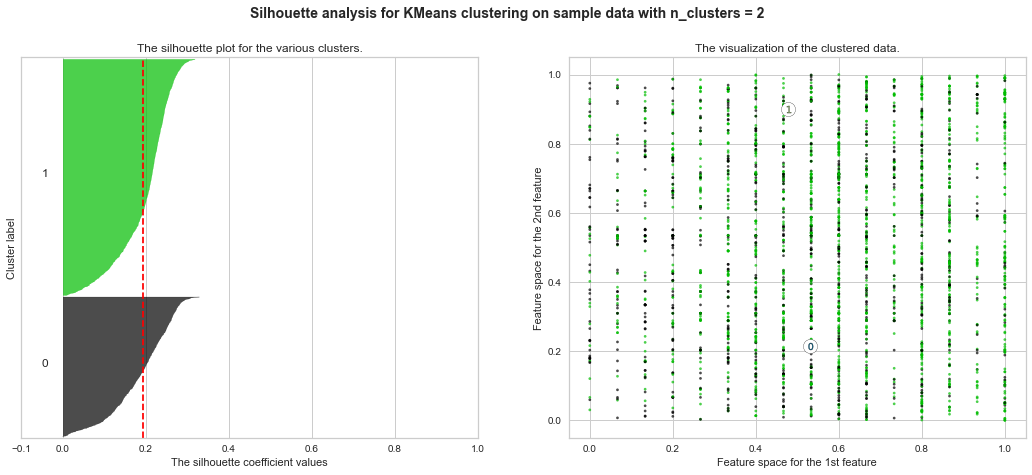

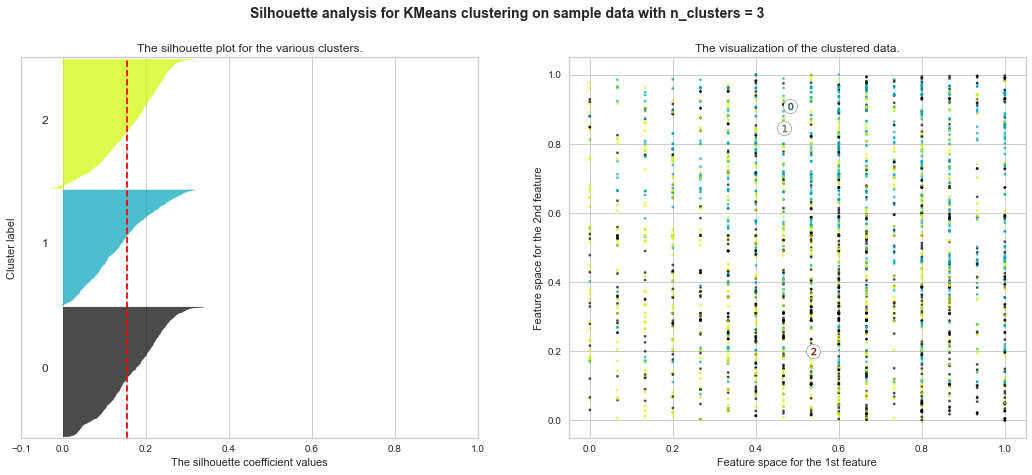

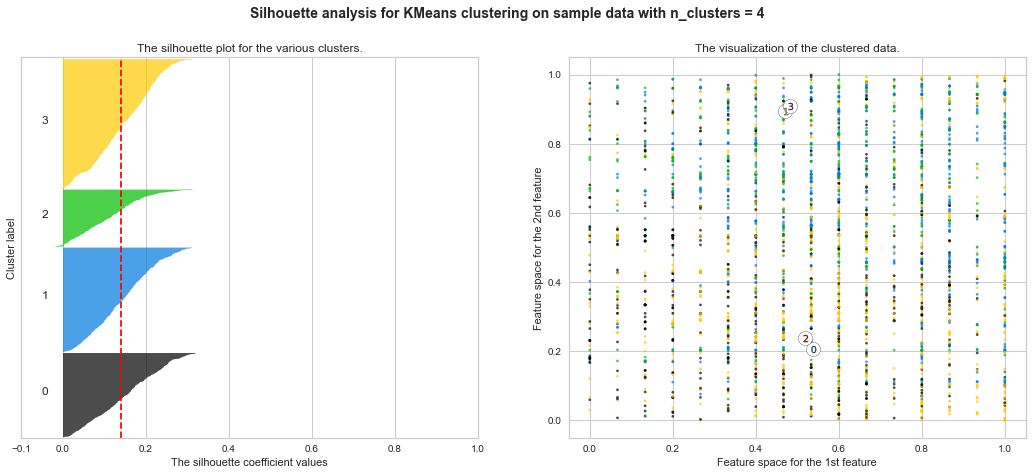

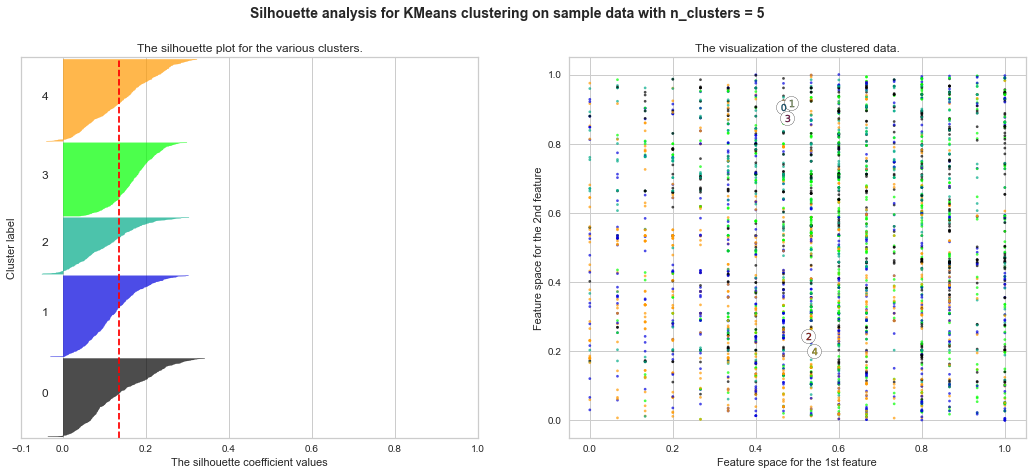

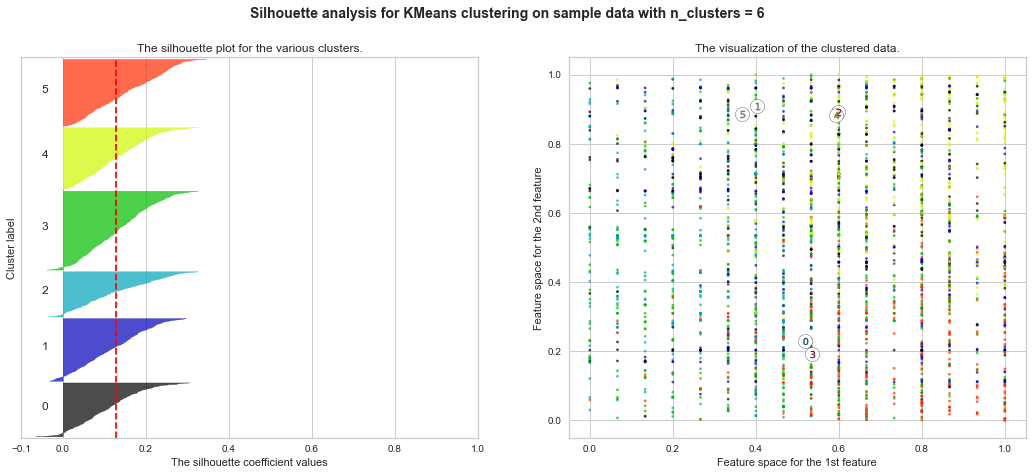

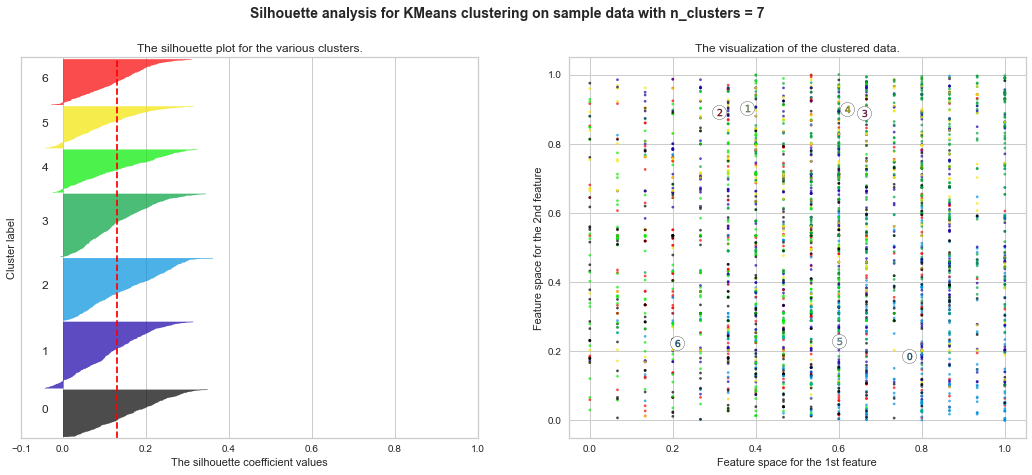

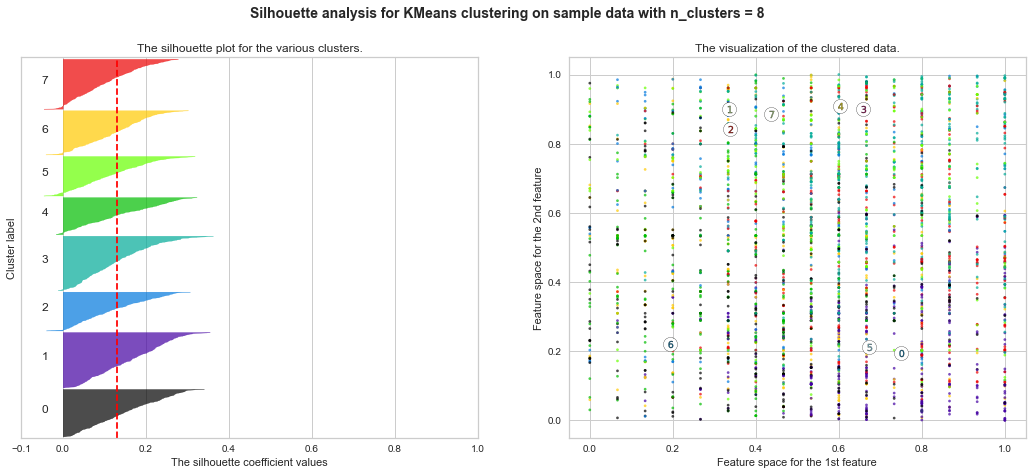

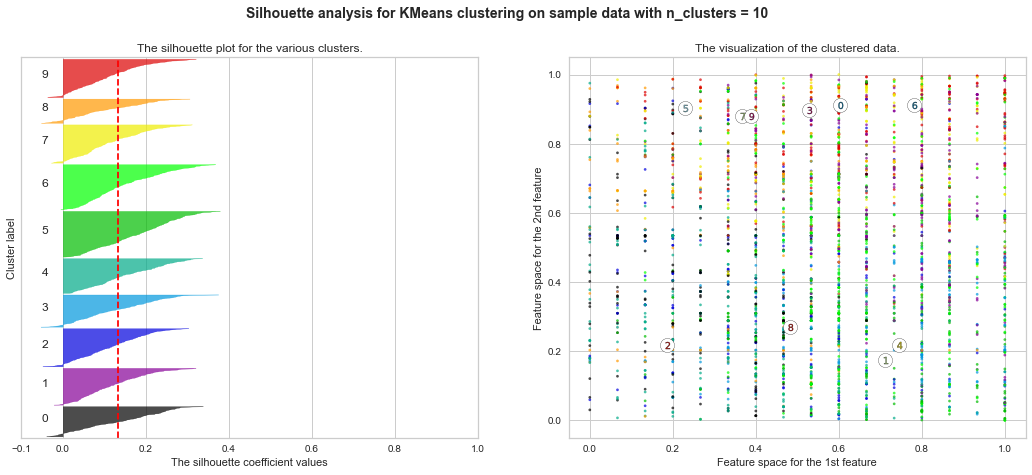

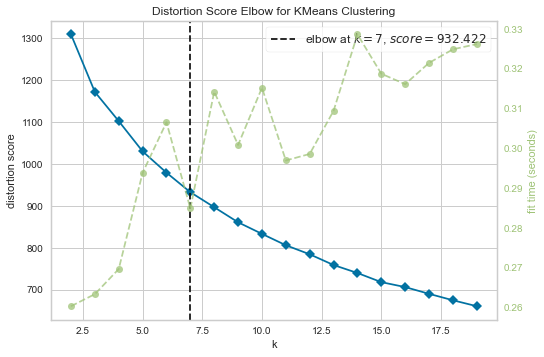

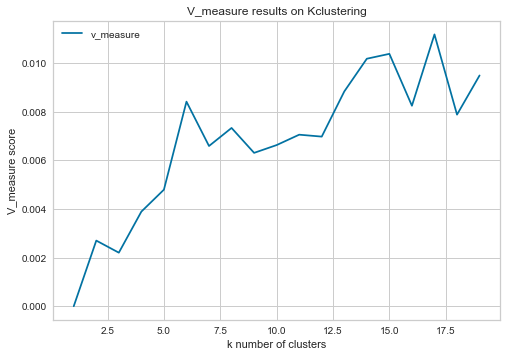

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

##data loaded
data=pd.read_csv('chocolate_bars.csv',index_col=0)
data.head(-5)
##filing the missing datas
#filling the missing tables with the most common ingredients
data['ingredients'].fillna(data['ingredients'].mode()[0], inplace=True)
data['num_ingredients'].fillna(data['num_ingredients'].mode()[0], inplace=True)
#print(data)

# Importing LabelEncoder
from sklearn.preprocessing import LabelEncoder
# Instantiating LabelEncoder
le=LabelEncoder()
# Iterating over all the values of each column and extract their dtypes
for col in data.columns.to_numpy():
    # Comparing if the dtype is object
    if data[col].dtypes in ('object','category'):
    # Using LabelEncoder to do the numeric transformation
        data[col]=le.fit_transform(data[col].astype(str))
        
#Binning the rating column
cut_labels = ['really bad', 'bad', 'ok', 'good']
cut_bins = [0, 0.99,1.99,2.99,4.0]
data['rating'] = pd.cut(data['rating'], bins=cut_bins, labels=cut_labels)


#creating the testing and training variables
x=data.drop("rating",axis=1)
y=data["rating"]

# Normalize feature data
scaler = MinMaxScaler()
X= scaler.fit_transform(x)
print(X.shape)

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:,2], X[:,4], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,20), metric='distortion')
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

labels_true=y
v_measure_list=[]
for k in range(1,20):
    clusterer = KMeans(n_clusters=k, random_state=42)
    labels_pred = clusterer.fit_predict(X)
    score=metrics.v_measure_score(labels_true, clusterer.labels_)
    v_measure_list.append(score)

k_clusters=[k for k in range(1,20)]
fig, ax1=plt.subplots()
ax1.plot(k_clusters, v_measure_list,label="v_measure")
ax1.set_title('V_measure results on Kclustering')
ax1.set_xlabel('k number of clusters')
ax1.set_ylabel('V_measure score')
ax1.legend()
plt.show()